# COCO Reader with Augmentations

Here is an example that demonstrates how to combine the COCO Reader, which loads data from a COCO dataset, with some of the typical augmentations used in image detection and segmentation use cases. The COCO dataset consists of a directory with images and an annotations file containing information about bounding boxes, labels and segmentation masks.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.types as types
import nvidia.dali.fn as fn  # Using DALI's functional style API
import nvidia.dali.math as math  # Using DALI's functional style API
import numpy as np
from time import time
import os.path

import random
random.seed(1231231)   # Random is used to pick colors

test_data_root = os.environ['DALI_EXTRA_PATH']
file_root = os.path.join(test_data_root, 'db', 'coco', 'images')
annotations_file = os.path.join(test_data_root, 'db', 'coco', 'instances.json')

num_gpus = 1     # Single GPU for this example
device_id = 0
batch_size = 32
num_threads = 4  # Number of CPU threads

Let us start by defining a simple pipeline that just loads the data

In [2]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id)
with pipe:
    inputs, bboxes, labels, polygons, vertices = fn.coco_reader(
        file_root=file_root,
        annotations_file=annotations_file,
        polygon_masks=True, # Load segmentation mask data as polygons 
        ltrb=True,          # Bounding boxes to be expressed as left, top, right, bottom coordinates
    )
    images = fn.image_decoder(inputs, device='mixed')
    pipe.set_outputs(images, bboxes, labels, polygons, vertices)
pipe.build()

We can now run the pipeline and visualize the results

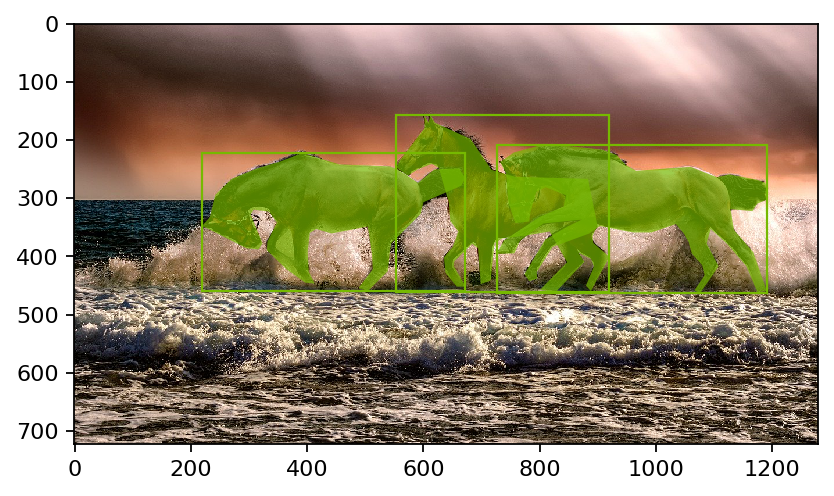

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_coco_sample(image, bboxes, labels, mask_polygons, mask_vertices, relative_coords=False):
    H, W = image.shape[0], image.shape[1]
    fig, ax = plt.subplots(dpi=160)
    
    # Displaying the image
    ax.imshow(image)
    
    # Bounding boxes
    for bbox, label in zip(bboxes, labels):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t), 
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax.add_patch(rect)

    # Segmentation masks
    for polygon in mask_polygons:
        mask_idx, start_vertex, end_vertex = polygon
        polygon_vertices = mask_vertices[start_vertex:end_vertex]  # Select polygon vertices
        # Scale relative coordinates to the image dimensions, if necessary
        polygon_vertices = polygon_vertices * [W, H] if relative_coords else polygon_vertices
        poly = patches.Polygon(polygon_vertices, True, facecolor='#76b900', alpha=0.7)
        ax.add_patch(poly)
    
    plt.show()
    
def show(outputs, relative_coords=False):
    i = 16  # Picked a sample idx that shows more than one bounding box
    images, bboxes, labels, mask_polygons, mask_vertices = outputs
    plot_coco_sample(images.as_cpu().at(i), bboxes.at(i), labels.at(i), 
                     mask_polygons.at(i), mask_vertices.at(i),
                     relative_coords=relative_coords)

outputs = pipe.run()
show(outputs)

A typical augmentation applied in detection and segmentation use cases is a random crop of the image with the restriction that at least one ground truth box is present in the cropped image. In DALI, we use RandomBBoxCrop for that. RandomBBoxCrop operator takes as an input the bounding boxes and the labels associated with them, and a set of constraints for the cropping operation. The result are the cropping window anchor and shape, as well as the processed bounding boxes and labels. The anchor and shape outputs, expressed in relative coordinates, can be directly fed into DALI's Slice operator to extract the region of interest of the image. The output bounding boxes and labels are processed to contain only the ones within the cropping window, and the coordinates are mapped to the new coordinate space. RandomBBoxCrop does not process segmentation masks, so the mask coordinates need to be mapped to the new coordinate space separately.

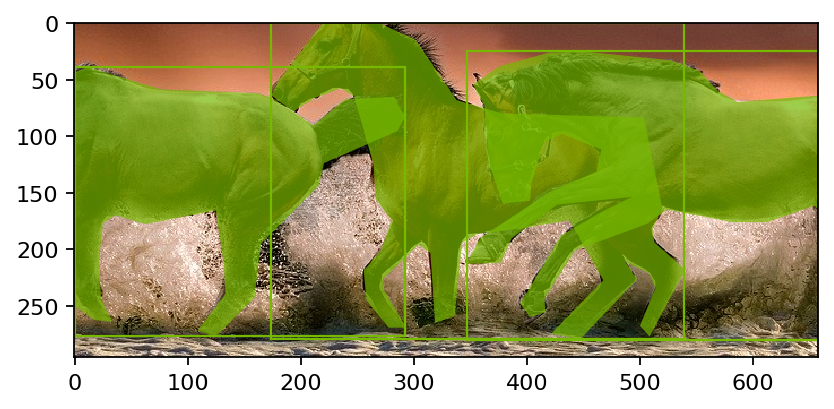

In [4]:
# Wrapping the pipeline definition in separate functions that we can reuse it later

def coco_reader_def():
    inputs, bboxes, labels, polygons, vertices = fn.coco_reader(
        file_root=file_root,
        annotations_file=annotations_file,
        polygon_masks=True, # Load segmentation mask data as polygons 
        ratio=True,         # Bounding box and mask polygons to be expressed in relative coordinates
        ltrb=True,          # Bounding boxes to be expressed as left, top, right, bottom coordinates
    )
    return inputs, bboxes, labels, polygons, vertices

def random_bbox_crop_def(bboxes, labels, polygons, vertices):
    # RandomBBoxCrop works with relative coordinates
    # The arguments have been selected to produce a significantly visible crop
    # To learn about all the available options, see the documentation
    anchor_rel, shape_rel, bboxes, labels, bbox_indices = fn.random_bbox_crop(
        bboxes,
        labels,
        aspect_ratio=[0.5, 2],     # Range of aspect ratios
        thresholds=[0.0],          # No minimum intersection-over-union, for demo purposes
        allow_no_crop=False,       # No-crop is disallowed, for demo purposes 
        scaling=[0.3, 0.6],        # Scale range of the crop with respect to the image shape
        seed=12345,                # Fixed random seed for deterministic results
        bbox_layout="xyXY",        # left, top, right, back
        output_bbox_indices=True,  # Output indices of the filtered bounding boxes
    )
    
    # Select mask polygons of those bounding boxes that remained in the image
    polygons, vertices = fn.segmentation.select_masks(
        bbox_indices, polygons, vertices
    )
    
    return anchor_rel, shape_rel, bboxes, labels, polygons, vertices

pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id)
with pipe:
    inputs, bboxes, labels, polygons, vertices = coco_reader_def()
    anchor_rel, shape_rel, bboxes, labels, polygons, vertices = \
        random_bbox_crop_def(bboxes, labels, polygons, vertices)
    
    # Partial decoding of the image
    images = fn.image_decoder_slice(
        inputs, anchor_rel, shape_rel, normalized_anchor=True, normalized_shape=True, device='cpu'
    )
    # Cropped image dimensions
    crop_shape = fn.shapes(images, dtype=types.FLOAT)
    crop_h = fn.slice(crop_shape, 0, 1, axes=[0])
    crop_w = fn.slice(crop_shape, 1, 1, axes=[0])

    images = images.gpu()

    # If necessary, clamp the coordinates
    vertices = math.clamp(vertices, 0.0, 1.0)

    # Adjust masks coordinates to the coordinate space of the cropped image, while also converting
    # relative to absolute coordinates by mapping the top-left corner (anchor_rel_x, anchor_rel_y), to (0, 0) 
    # and the bottom-right corner (anchor_rel_x+shape_rel_x, anchor_rel_y+shape_rel_y) to (crop_w, crop_h)
    MT_vertices = fn.transforms.crop(
        from_start=anchor_rel, from_end=(anchor_rel + shape_rel),
        to_start=(0.0, 0.0), to_end=fn.cat(crop_w, crop_h)
    )    
    vertices = fn.coord_transform(vertices, MT=MT_vertices)
    
    # Convert bounding boxes to absolute coordinates
    MT_bboxes = fn.transforms.crop(
        to_start=(0.0, 0.0, 0.0, 0.0), to_end=fn.cat(crop_w, crop_h, crop_w, crop_h)
    )
    bboxes = fn.coord_transform(bboxes, MT=MT_bboxes)

    pipe.set_outputs(images, bboxes, labels, polygons, vertices)

pipe.build()
outputs = pipe.run()
show(outputs)

In the following pipeline, we paste the image to a larger canvas and flip it horizontally

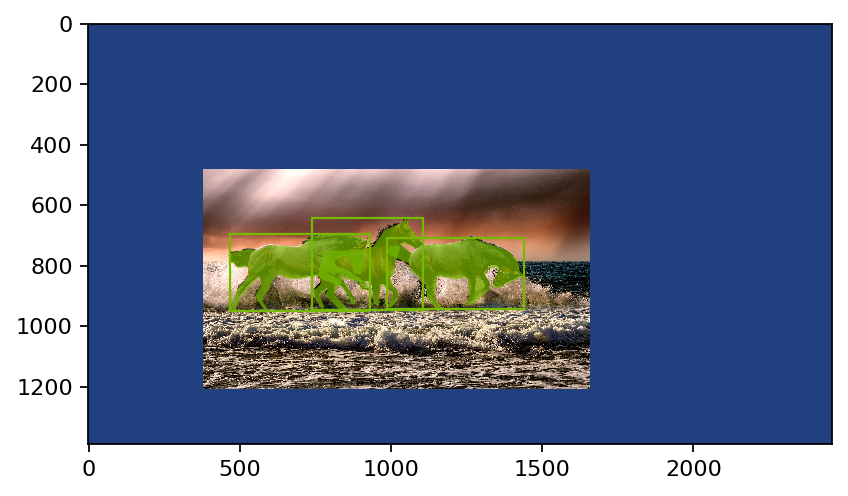

In [5]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id, seed=12345)
with pipe:
    inputs, bboxes, labels, polygons, vertices = coco_reader_def()
    orig_shape = fn.peek_image_shape(inputs)
    images = fn.image_decoder(inputs)
    images = images.gpu()
    px = fn.uniform(range=(0, 1))
    py = fn.uniform(range=(0, 1))
    ratio = fn.uniform(range=(1, 2))
    images = fn.paste(images, paste_x=px, paste_y=py, ratio=ratio, fill_value=(32, 64, 128))
    bboxes = fn.bbox_paste(bboxes, paste_x=px, paste_y=py, ratio=ratio, ltrb=True)

    scale = 1.0 / ratio
    margin = ratio - 1.0
    px_1 = scale * px * margin
    py_1 = scale * py * margin
    ver_x = scale * fn.slice(vertices, 0, 1, axes=[1]) + px_1
    ver_y = scale * fn.slice(vertices, 1, 1, axes=[1]) + py_1
    vertices = fn.cat(ver_x, ver_y, axis=1)
    
    should_flip = fn.coin_flip(probability=1.0)  # 100% probability for demo purposes
    images = fn.flip(images, horizontal=should_flip)
    bboxes = fn.bb_flip(bboxes, horizontal=should_flip, ltrb=True)
    vertices = fn.coord_flip(vertices, flip_x=should_flip)
    
    pipe.set_outputs(images, bboxes, labels, polygons, vertices)

pipe.build()
outputs = pipe.run()
show(outputs, relative_coords=True)